In [19]:
# Imports
import cv2
import glob
import os.path
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np

from scipy.ndimage.measurements import label

from skimage.feature import hog
from skimage import color, exposure
from sklearn.calibration import CalibratedClassifierCV
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

import features as F


In [2]:
# Load Data and Feature engineering.

def LoadData(imagePath):
    images = glob.glob(imagePath)
    data = []

    for image in images:
        data.append(image)
    return data

carTrainDataPath = "./data/vehicles/*/*.png"
carTestDataPath = "./data/vehicles/*/test/*.png"

carsTrain = LoadData(carTrainDataPath)
carsTest = LoadData(carTestDataPath)

notCarPath = "./data/non-vehicles/*/*.png"
notCars = LoadData(notCarPath)

f = F.Features()

carTrainData_features = f.extract_features(carsTrain)
carTestData_features = f.extract_features(carsTest)
allcar_features = carTrainData_features + carTestData_features

notcar_features = f.extract_features(notCars)
rand_state = np.random.randint(0, 100)
notcar_features_train, notcar_features_test = train_test_split(notcar_features, train_size = 0.78, random_state=rand_state)

# Prepare Features.
print("Number of vehicles images: ", len(carTrainData_features), " ", len(carTestData_features), " ", len(allcar_features))
print("Number of non-vehicles images: ", len(notcar_features_train), " ", len(notcar_features_test), " ", len(notcar_features))



Number of vehicles images:  6824   1968   8792
Number of non-vehicles images:  6995   1973   8968


In [3]:
# Train and Save Classifier

# Create an array stack of feature vectors
X = np.vstack((allcar_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)


# Apply the scaler to X
carTrainData_features = X_scaler.transform(carTrainData_features)
carTestData_features = X_scaler.transform(carTestData_features)
notcar_features_train = X_scaler.transform(notcar_features_train)
notcar_features_test = X_scaler.transform(notcar_features_test)

X_train = np.vstack((carTrainData_features, notcar_features_train)).astype(np.float64)                        
y_train = np.hstack((np.ones(len(carTrainData_features)), np.zeros(len(notcar_features_train))))

X_test = np.vstack((carTestData_features, notcar_features_test)).astype(np.float64)                        
y_test = np.hstack((np.ones(len(carTestData_features)), np.zeros(len(notcar_features_test))))

rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state=0)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
clf = CalibratedClassifierCV(svc)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
print('Train Accuracy of SVC = ', round(clf.score(X_train, y_train), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
print('with probability: ', clf.predict_proba(X_test[0:n_predict]))

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
# Save model & scaler
print("Saving models...")
joblib.dump(svc, './models/classifier.pkl')
joblib.dump(clf, './models/calibrated.pkl')
joblib.dump(X_scaler, './models/scaler.pkl')
print("Done!")

Feature vector length: 8460
74.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9774
Train Accuracy of SVC =  1.0
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
with probability:  [[  2.01286101e-07   9.99999799e-01]
 [  5.56677737e-03   9.94433223e-01]
 [  3.93997365e-06   9.99996060e-01]
 [  9.92508599e-06   9.99990075e-01]
 [  1.96932310e-06   9.99998031e-01]
 [  3.10783143e-05   9.99968922e-01]
 [  5.94967645e-04   9.99405032e-01]
 [  6.94924763e-04   9.99305075e-01]
 [  3.15603267e-03   9.96843967e-01]
 [  4.89626390e-04   9.99510374e-01]]
0.01281 Seconds to predict 10 labels with SVC
Saving models...
Done!


In [20]:
# Load Models

# Load the classifier model
svc = joblib.load('./models/classifier.pkl')
clf = joblib.load('./models/calibrated.pkl')

# Load the standard scalar model
X_scaler = joblib.load('./models/scaler.pkl')

In [33]:
# Utility functions for feature engineering    

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Draw the surrounding box
    font = cv2.FONT_HERSHEY_SIMPLEX
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates        
#         print(bbox)
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a single function that can extract features and make predictions
def find_cars(img, windows):
    possible_cars = []
    f = F.Features()
    # Iterate over all windows in the list
    positive_predictions = 0
    positive_predictions_above_threshold = 0
    for w in windows:
        # Extract the test window from original image
        sub_image = img[w[0][1]:w[1][1], w[0][0]:w[1][0]]
        test_img = cv2.resize(sub_image, (64, 64))
        # Extract features for that window 
        features = f.extract_features_image(test_img)
        # Scale extracted features to be fed to classifier
        test_features = X_scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            # Confidence score
            confidence_score = clf.predict_proba(test_features)
#             print("confidence_score", confidence_score[0][1])
            if confidence_score[0][1] > 0.8:   # probability threshold for positive detection
                possible_cars.append(w)
                positive_predictions_above_threshold += 1
            positive_predictions += 1
    # Return windows for positive detections
    print("positive_predictions:", positive_predictions)
    print("positive_predictions_above_threshold:", positive_predictions_above_threshold)
    return possible_cars

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

# Define a single function that can extract features and make predictions
def harden_detections(image, possible_cars):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, possible_cars)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    print("Labels:", labels[1])

    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [34]:
import pipeline as p

def process_image(img, debug=False):
    scaled_img = img.astype(np.float32)/255
    windows = p.getWindows(scaled_img)
    print("all:", len(windows))
    possible_cars = find_cars(scaled_img, windows)
    print("possible_cars:", len(possible_cars))
    final_img = harden_detections(img, possible_cars)
    
    if debug:
        pre_filter_img = draw_boxes(img, possible_cars)
        return final_img, pre_filter_img
    else:
        return final_img


Testing image ./test_images/test1.jpg
all: 4119
positive_predictions: 140
positive_predictions_above_threshold: 66
possible_cars: 66
Labels: 2
Testing image ./test_images/test2.jpg
all: 4119
positive_predictions: 26
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
Testing image ./test_images/test3.jpg
all: 4119
positive_predictions: 41
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
Testing image ./test_images/test4.jpg
all: 4119
positive_predictions: 136
positive_predictions_above_threshold: 67
possible_cars: 67
Labels: 2
Testing image ./test_images/test5.jpg
all: 4119
positive_predictions: 260
positive_predictions_above_threshold: 124
possible_cars: 124
Labels: 3
Testing image ./test_images/test6.jpg
all: 4119
positive_predictions: 140
positive_predictions_above_threshold: 92
possible_cars: 92
Labels: 4


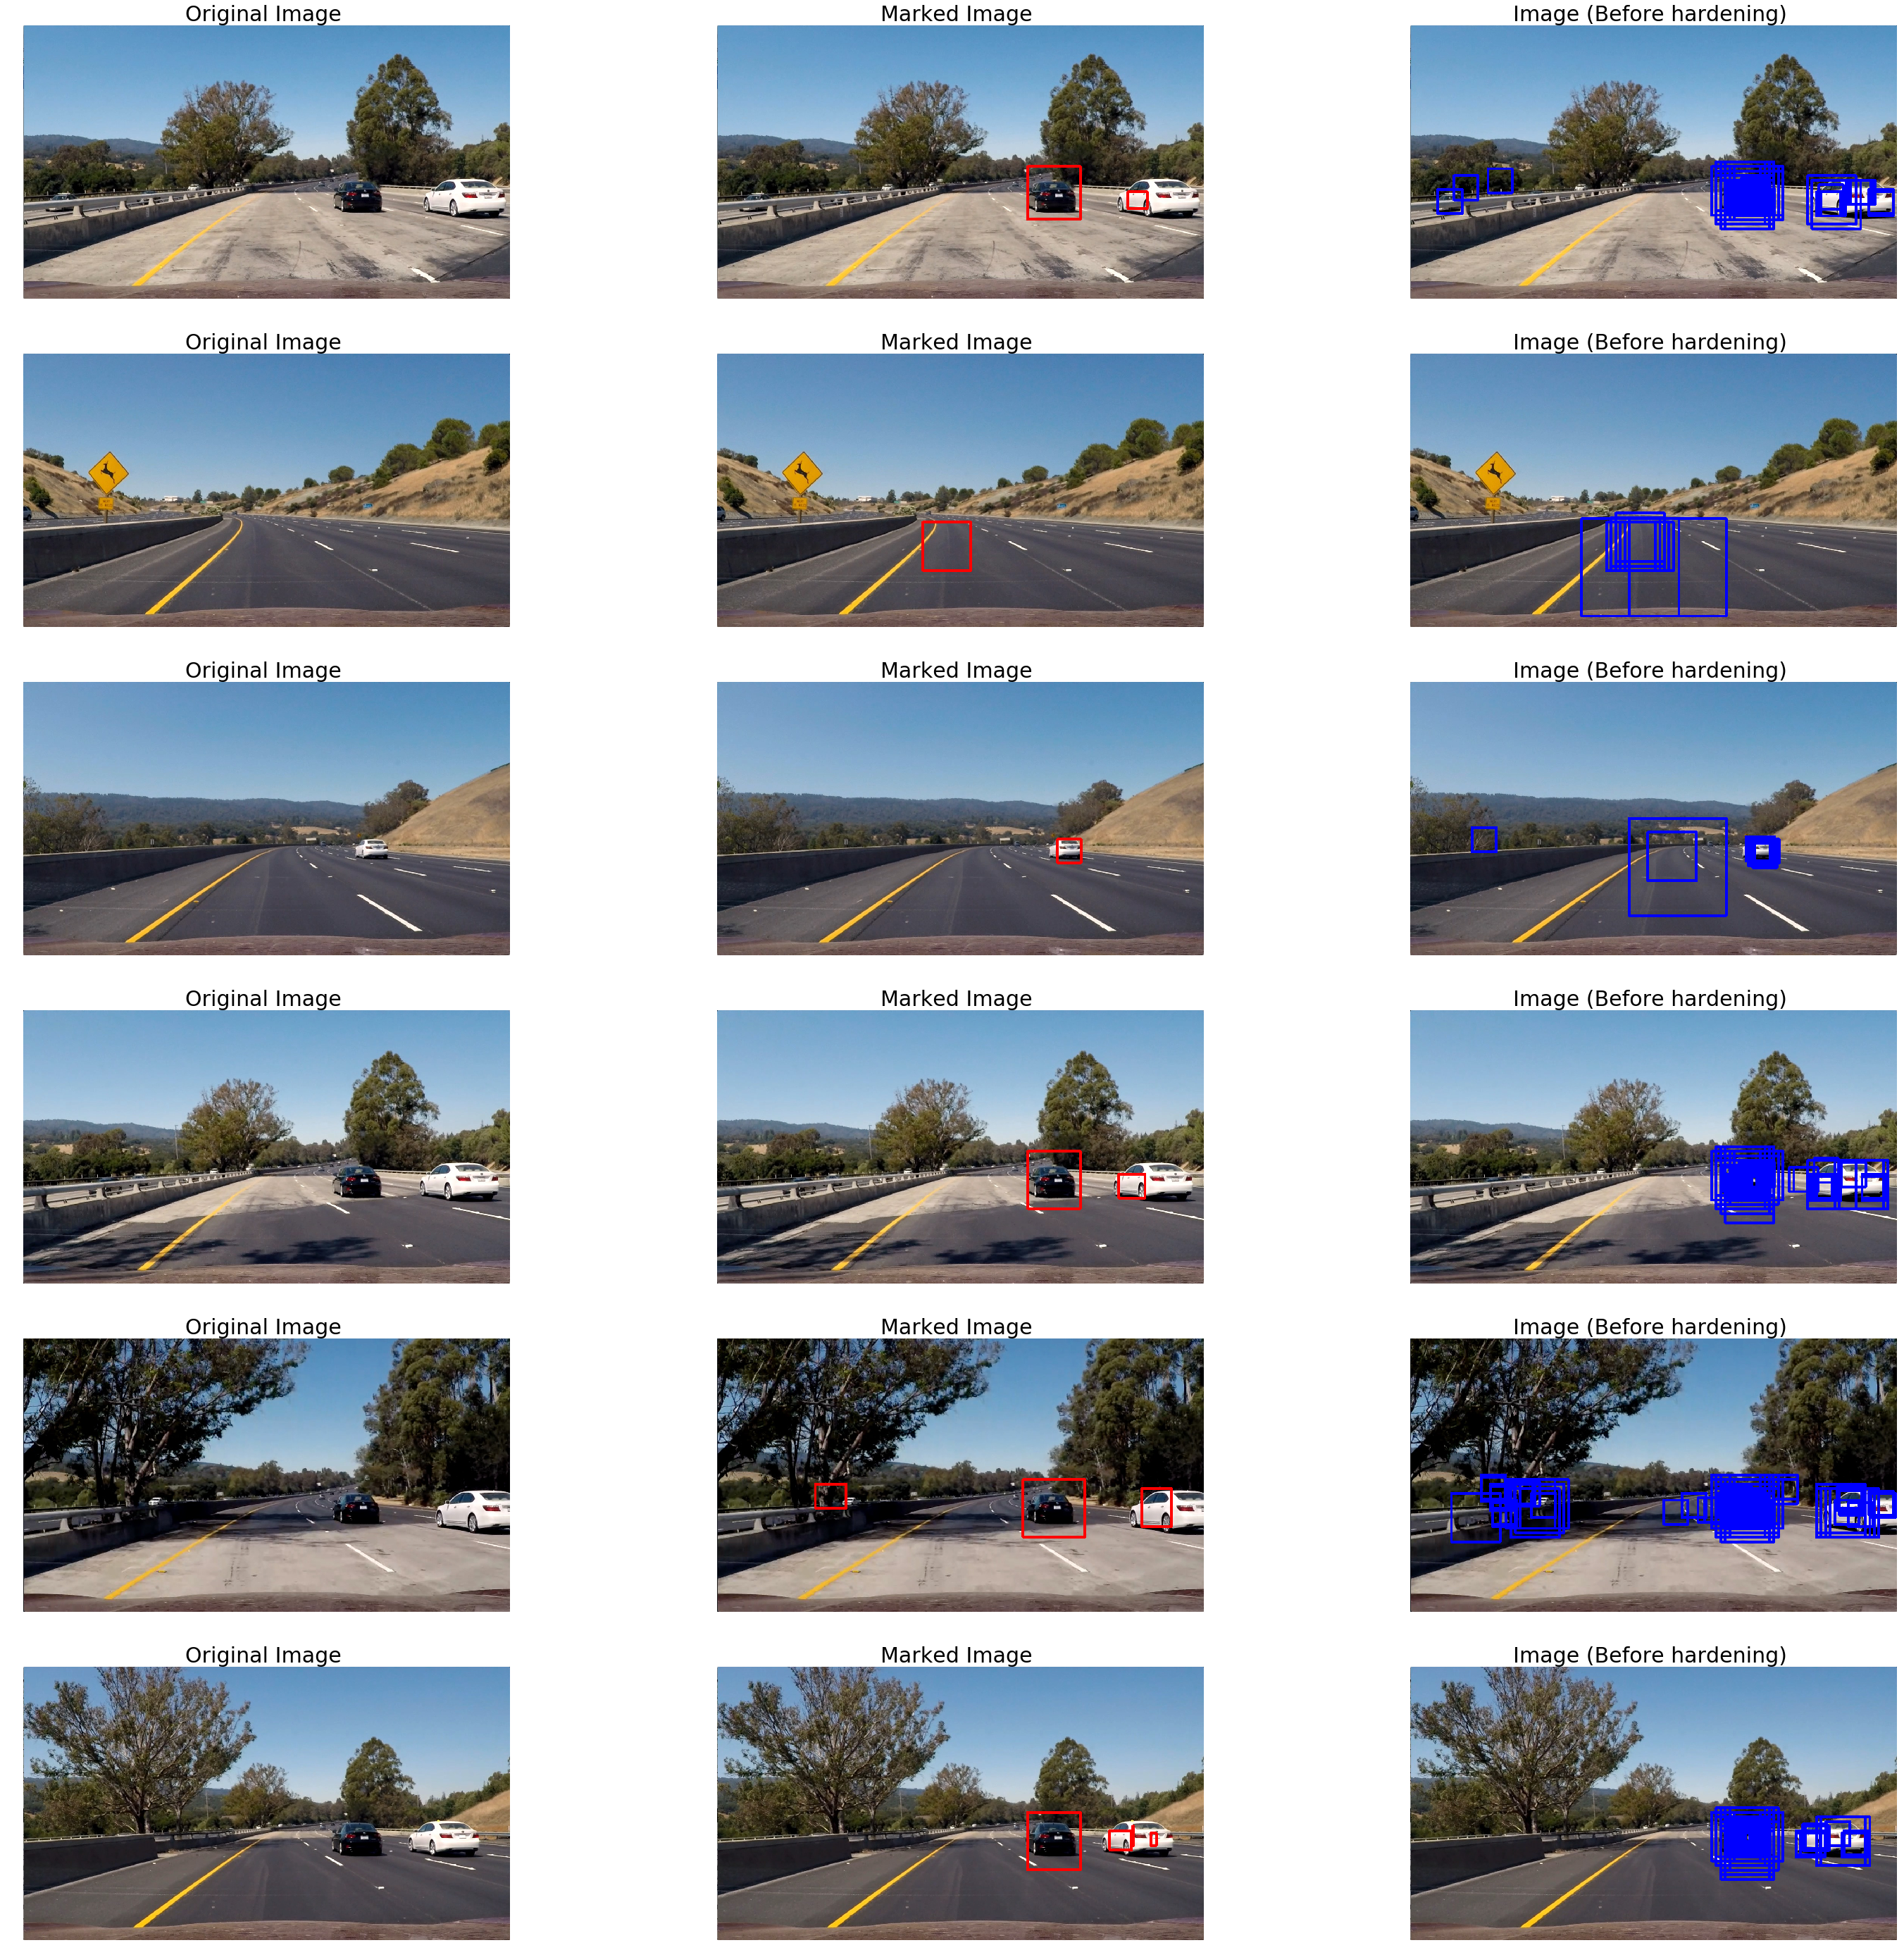

In [35]:
# Test images

image_path = "./test_images/*.jpg"
images = glob.glob(image_path)

fig = plt.figure()
fig.set_size_inches(50,50)

total_image_count = len(images)
image_count = 1

for fname in images:
    print("Testing image {}".format(fname))

    img = mpimg.imread(fname)
    marked_img, pre_filter_img = process_image(img, debug=True)

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title('Original Image ', fontsize=30)
    image_count += 1

    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(marked_img)
    ax.axis('off')
    ax.set_title('Marked Image ', fontsize=30)
    image_count += 1

    
    ax = fig.add_subplot(total_image_count, 3, image_count)
    ax.imshow(pre_filter_img)
    ax.axis('off')
    ax.set_title('Image (Before hardening) ', fontsize=30)
    image_count += 1
    
    cv2.imwrite('./output_images/Marked_' + os.path.split(fname)[-1], marked_img)
    cv2.imwrite('./output_images/pre_filter_img_' + os.path.split(fname)[-1], pre_filter_img)

plt.show()


In [ ]:
# Test Video
clip1 = VideoFileClip("./project_video.mp4")
clip = clip.subclip(38, 43)
# clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_marked.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)


all: 4119
positive_predictions: 18
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
[MoviePy] >>>> Building video ./project_video_marked.mp4
[MoviePy] Writing video ./project_video_marked.mp4


  0%|          | 0/376 [00:00<?, ?it/s]

all: 4119


  0%|          | 1/376 [00:14<1:30:15, 14.44s/it]

positive_predictions: 18
positive_predictions_above_threshold: 1
possible_cars: 1
Labels: 0
all: 4119


  1%|          | 2/376 [00:29<1:30:30, 14.52s/it]

positive_predictions: 31
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 0
all: 4119


  1%|          | 3/376 [00:44<1:30:53, 14.62s/it]

positive_predictions: 19
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 4119


  1%|          | 4/376 [00:58<1:31:02, 14.68s/it]

positive_predictions: 24
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 0
all: 4119


  1%|▏         | 5/376 [01:13<1:30:17, 14.60s/it]

positive_predictions: 22
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 0
all: 4119


  2%|▏         | 6/376 [01:27<1:30:10, 14.62s/it]

positive_predictions: 40
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
all: 4119


  2%|▏         | 7/376 [01:42<1:30:40, 14.74s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 4119


  2%|▏         | 8/376 [01:57<1:30:27, 14.75s/it]

positive_predictions: 34
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 1
all: 4119


  2%|▏         | 9/376 [02:12<1:30:02, 14.72s/it]

positive_predictions: 25
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 0
all: 4119


  3%|▎         | 10/376 [02:26<1:29:22, 14.65s/it]

positive_predictions: 40
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 1
all: 4119


  3%|▎         | 11/376 [02:41<1:29:18, 14.68s/it]

positive_predictions: 43
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 0
all: 4119


  3%|▎         | 12/376 [02:56<1:29:06, 14.69s/it]

positive_predictions: 41
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
all: 4119


  3%|▎         | 13/376 [03:11<1:29:01, 14.72s/it]

positive_predictions: 40
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
all: 4119


  4%|▎         | 14/376 [03:25<1:29:07, 14.77s/it]

positive_predictions: 37
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 4119


  4%|▍         | 15/376 [03:40<1:29:14, 14.83s/it]

positive_predictions: 38
positive_predictions_above_threshold: 12
possible_cars: 12
Labels: 1
all: 4119


  4%|▍         | 16/376 [03:55<1:29:02, 14.84s/it]

positive_predictions: 35
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 4119


  5%|▍         | 17/376 [04:11<1:29:37, 14.98s/it]

positive_predictions: 41
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
all: 4119


  5%|▍         | 18/376 [04:25<1:29:09, 14.94s/it]

positive_predictions: 39
positive_predictions_above_threshold: 13
possible_cars: 13
Labels: 1
all: 4119


  5%|▌         | 19/376 [04:40<1:28:53, 14.94s/it]

positive_predictions: 44
positive_predictions_above_threshold: 20
possible_cars: 20
Labels: 2
all: 4119


  5%|▌         | 20/376 [04:55<1:28:13, 14.87s/it]

positive_predictions: 29
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 4119


  6%|▌         | 21/376 [05:10<1:27:56, 14.86s/it]

positive_predictions: 29
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 4119


  6%|▌         | 22/376 [05:25<1:27:23, 14.81s/it]

positive_predictions: 34
positive_predictions_above_threshold: 10
possible_cars: 10
Labels: 1
all: 4119


  6%|▌         | 23/376 [05:39<1:26:50, 14.76s/it]

positive_predictions: 31
positive_predictions_above_threshold: 8
possible_cars: 8
Labels: 1
all: 4119


  6%|▋         | 24/376 [05:54<1:26:13, 14.70s/it]

positive_predictions: 30
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 4119


  7%|▋         | 25/376 [06:09<1:25:54, 14.69s/it]

positive_predictions: 32
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 1
all: 4119


  7%|▋         | 26/376 [06:23<1:25:43, 14.70s/it]

positive_predictions: 25
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 0
all: 4119


  7%|▋         | 27/376 [06:38<1:25:26, 14.69s/it]

positive_predictions: 26
positive_predictions_above_threshold: 3
possible_cars: 3
Labels: 0
all: 4119


  7%|▋         | 28/376 [06:53<1:25:39, 14.77s/it]

positive_predictions: 33
positive_predictions_above_threshold: 11
possible_cars: 11
Labels: 1
all: 4119


  8%|▊         | 29/376 [07:08<1:25:23, 14.76s/it]

positive_predictions: 27
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 0
all: 4119


  8%|▊         | 30/376 [07:23<1:25:22, 14.81s/it]

positive_predictions: 30
positive_predictions_above_threshold: 5
possible_cars: 5
Labels: 0
all: 4119


  8%|▊         | 31/376 [07:37<1:25:17, 14.83s/it]

positive_predictions: 25
positive_predictions_above_threshold: 2
possible_cars: 2
Labels: 0
all: 4119


  9%|▊         | 32/376 [07:52<1:24:44, 14.78s/it]

positive_predictions: 34
positive_predictions_above_threshold: 9
possible_cars: 9
Labels: 1
all: 4119


  9%|▉         | 33/376 [08:07<1:24:48, 14.83s/it]

positive_predictions: 26
positive_predictions_above_threshold: 6
possible_cars: 6
Labels: 0
all: 4119


  9%|▉         | 34/376 [08:22<1:24:49, 14.88s/it]

positive_predictions: 31
positive_predictions_above_threshold: 7
possible_cars: 7
Labels: 0
all: 4119


  9%|▉         | 35/376 [08:37<1:24:35, 14.89s/it]

positive_predictions: 36
positive_predictions_above_threshold: 15
possible_cars: 15
Labels: 1
all: 4119


 10%|▉         | 36/376 [08:51<1:23:46, 14.78s/it]

positive_predictions: 40
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 1
all: 4119


 10%|▉         | 37/376 [09:06<1:23:06, 14.71s/it]

positive_predictions: 50
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 3
all: 4119


 10%|█         | 38/376 [09:21<1:22:32, 14.65s/it]

positive_predictions: 54
positive_predictions_above_threshold: 20
possible_cars: 20
Labels: 2
all: 4119


 10%|█         | 39/376 [09:36<1:22:53, 14.76s/it]

positive_predictions: 64
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 2
all: 4119


 11%|█         | 40/376 [09:56<1:31:53, 16.41s/it]

positive_predictions: 51
positive_predictions_above_threshold: 20
possible_cars: 20
Labels: 2
all: 4119


 11%|█         | 41/376 [10:11<1:28:49, 15.91s/it]

positive_predictions: 54
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 2
all: 4119


 11%|█         | 42/376 [10:25<1:26:39, 15.57s/it]

positive_predictions: 50
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 2
all: 4119


 11%|█▏        | 43/376 [12:16<4:05:31, 44.24s/it]

positive_predictions: 59
positive_predictions_above_threshold: 19
possible_cars: 19
Labels: 1
all: 4119


 12%|█▏        | 44/376 [12:33<3:18:29, 35.87s/it]

positive_predictions: 55
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 1
all: 4119


 12%|█▏        | 45/376 [12:48<2:43:44, 29.68s/it]

positive_predictions: 48
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 3
all: 4119


 12%|█▏        | 46/376 [13:03<2:18:40, 25.21s/it]

positive_predictions: 46
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 1
all: 4119


 12%|█▎        | 47/376 [13:18<2:01:19, 22.13s/it]

positive_predictions: 51
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 13%|█▎        | 48/376 [13:32<1:48:37, 19.87s/it]

positive_predictions: 55
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 2
all: 4119


 13%|█▎        | 49/376 [13:47<1:39:54, 18.33s/it]

positive_predictions: 50
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 13%|█▎        | 50/376 [14:02<1:33:59, 17.30s/it]

positive_predictions: 46
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 1
all: 4119


 14%|█▎        | 51/376 [14:17<1:29:54, 16.60s/it]

positive_predictions: 55
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 1
all: 4119


 14%|█▍        | 52/376 [14:32<1:27:33, 16.21s/it]

positive_predictions: 51
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 14%|█▍        | 53/376 [14:48<1:26:36, 16.09s/it]

positive_predictions: 48
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 1
all: 4119


 14%|█▍        | 54/376 [15:03<1:25:13, 15.88s/it]

positive_predictions: 51
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 1
all: 4119


 15%|█▍        | 55/376 [15:19<1:24:01, 15.71s/it]

positive_predictions: 49
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 2
all: 4119


 15%|█▍        | 56/376 [15:35<1:24:07, 15.77s/it]

positive_predictions: 53
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 15%|█▌        | 57/376 [15:51<1:24:28, 15.89s/it]

positive_predictions: 47
positive_predictions_above_threshold: 17
possible_cars: 17
Labels: 1
all: 4119


 15%|█▌        | 58/376 [16:06<1:23:30, 15.76s/it]

positive_predictions: 62
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 1
all: 4119


 16%|█▌        | 59/376 [16:21<1:20:56, 15.32s/it]

positive_predictions: 57
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 1
all: 4119


 16%|█▌        | 60/376 [16:35<1:18:49, 14.97s/it]

positive_predictions: 60
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 1
all: 4119


 16%|█▌        | 61/376 [16:51<1:20:20, 15.30s/it]

positive_predictions: 50
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 16%|█▋        | 62/376 [17:06<1:19:13, 15.14s/it]

positive_predictions: 55
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 2
all: 4119


 17%|█▋        | 63/376 [17:20<1:18:18, 15.01s/it]

positive_predictions: 50
positive_predictions_above_threshold: 29
possible_cars: 29
Labels: 2
all: 4119


 17%|█▋        | 64/376 [17:38<1:22:01, 15.77s/it]

positive_predictions: 55
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 2
all: 4119


 17%|█▋        | 65/376 [17:58<1:28:04, 16.99s/it]

positive_predictions: 57
positive_predictions_above_threshold: 33
possible_cars: 33
Labels: 2
all: 4119


 18%|█▊        | 66/376 [18:17<1:31:37, 17.73s/it]

positive_predictions: 64
positive_predictions_above_threshold: 30
possible_cars: 30
Labels: 2
all: 4119


 18%|█▊        | 67/376 [18:36<1:33:09, 18.09s/it]

positive_predictions: 57
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 2
all: 4119


 18%|█▊        | 68/376 [18:51<1:28:35, 17.26s/it]

positive_predictions: 64
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 2
all: 4119


 18%|█▊        | 69/376 [19:06<1:24:56, 16.60s/it]

positive_predictions: 72
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 2
all: 4119


 19%|█▊        | 70/376 [19:22<1:22:34, 16.19s/it]

positive_predictions: 59
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 2
all: 4119


 19%|█▉        | 71/376 [19:36<1:20:05, 15.76s/it]

positive_predictions: 63
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 3
all: 4119


 19%|█▉        | 72/376 [19:51<1:18:20, 15.46s/it]

positive_predictions: 48
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 2
all: 4119


 19%|█▉        | 73/376 [20:06<1:16:55, 15.23s/it]

positive_predictions: 62
positive_predictions_above_threshold: 29
possible_cars: 29
Labels: 2
all: 4119


 20%|█▉        | 74/376 [20:21<1:15:49, 15.06s/it]

positive_predictions: 65
positive_predictions_above_threshold: 31
possible_cars: 31
Labels: 2
all: 4119


 20%|█▉        | 75/376 [20:35<1:14:42, 14.89s/it]

positive_predictions: 51
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 2
all: 4119


 20%|██        | 76/376 [20:50<1:13:47, 14.76s/it]

positive_predictions: 65
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 1
all: 4119


 20%|██        | 77/376 [21:04<1:13:38, 14.78s/it]

positive_predictions: 64
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 1
all: 4119


 21%|██        | 78/376 [21:19<1:13:07, 14.72s/it]

positive_predictions: 51
positive_predictions_above_threshold: 20
possible_cars: 20
Labels: 1
all: 4119


 21%|██        | 79/376 [21:34<1:13:14, 14.80s/it]

positive_predictions: 56
positive_predictions_above_threshold: 14
possible_cars: 14
Labels: 1
all: 4119


 21%|██▏       | 80/376 [21:49<1:12:46, 14.75s/it]

positive_predictions: 50
positive_predictions_above_threshold: 18
possible_cars: 18
Labels: 1
all: 4119


 22%|██▏       | 81/376 [22:03<1:12:30, 14.75s/it]

positive_predictions: 57
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 2
all: 4119


 22%|██▏       | 82/376 [22:18<1:12:27, 14.79s/it]

positive_predictions: 65
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 3
all: 4119


 22%|██▏       | 83/376 [22:33<1:11:55, 14.73s/it]

positive_predictions: 75
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 3
all: 4119


 22%|██▏       | 84/376 [22:47<1:11:28, 14.69s/it]

positive_predictions: 69
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 3
all: 4119


 23%|██▎       | 85/376 [23:02<1:11:25, 14.73s/it]

positive_predictions: 72
positive_predictions_above_threshold: 31
possible_cars: 31
Labels: 2
all: 4119


 23%|██▎       | 86/376 [23:18<1:12:08, 14.92s/it]

positive_predictions: 68
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 2
all: 4119


 23%|██▎       | 87/376 [23:33<1:12:20, 15.02s/it]

positive_predictions: 67
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 2
all: 4119


 23%|██▎       | 88/376 [23:49<1:13:51, 15.39s/it]

positive_predictions: 68
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 1
all: 4119


 24%|██▎       | 89/376 [24:04<1:13:32, 15.37s/it]

positive_predictions: 82
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 1
all: 4119


 24%|██▍       | 90/376 [24:20<1:12:59, 15.31s/it]

positive_predictions: 72
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 2
all: 4119


 24%|██▍       | 91/376 [24:35<1:12:31, 15.27s/it]

positive_predictions: 67
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 1
all: 4119


 24%|██▍       | 92/376 [24:50<1:11:56, 15.20s/it]

positive_predictions: 60
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 3
all: 4119


 25%|██▍       | 93/376 [25:05<1:11:38, 15.19s/it]

positive_predictions: 67
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 3
all: 4119


 25%|██▌       | 94/376 [25:20<1:11:21, 15.18s/it]

positive_predictions: 63
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 2
all: 4119


 25%|██▌       | 95/376 [25:35<1:10:56, 15.15s/it]

positive_predictions: 63
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 2
all: 4119


 26%|██▌       | 96/376 [25:50<1:10:33, 15.12s/it]

positive_predictions: 69
positive_predictions_above_threshold: 33
possible_cars: 33
Labels: 3
all: 4119


 26%|██▌       | 97/376 [26:05<1:09:58, 15.05s/it]

positive_predictions: 76
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 2
all: 4119


 26%|██▌       | 98/376 [26:20<1:09:29, 15.00s/it]

positive_predictions: 94
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 2
all: 4119


 26%|██▋       | 99/376 [26:35<1:09:54, 15.14s/it]

positive_predictions: 82
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 2
all: 4119


 27%|██▋       | 100/376 [26:50<1:09:05, 15.02s/it]

positive_predictions: 74
positive_predictions_above_threshold: 27
possible_cars: 27
Labels: 2
all: 4119


 27%|██▋       | 101/376 [27:05<1:08:59, 15.05s/it]

positive_predictions: 76
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 4
all: 4119


 27%|██▋       | 102/376 [27:20<1:08:49, 15.07s/it]

positive_predictions: 75
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 4
all: 4119


 27%|██▋       | 103/376 [27:36<1:08:41, 15.10s/it]

positive_predictions: 87
positive_predictions_above_threshold: 30
possible_cars: 30
Labels: 5
all: 4119


 28%|██▊       | 104/376 [27:50<1:08:10, 15.04s/it]

positive_predictions: 70
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 2
all: 4119


 28%|██▊       | 105/376 [28:06<1:09:08, 15.31s/it]

positive_predictions: 68
positive_predictions_above_threshold: 26
possible_cars: 26
Labels: 2
all: 4119


 28%|██▊       | 106/376 [28:22<1:08:57, 15.32s/it]

positive_predictions: 65
positive_predictions_above_threshold: 27
possible_cars: 27
Labels: 2
all: 4119


 28%|██▊       | 107/376 [28:38<1:09:21, 15.47s/it]

positive_predictions: 47
positive_predictions_above_threshold: 24
possible_cars: 24
Labels: 1
all: 4119


 29%|██▊       | 108/376 [28:53<1:08:57, 15.44s/it]

positive_predictions: 67
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 2
all: 4119


 29%|██▉       | 109/376 [29:08<1:08:14, 15.34s/it]

positive_predictions: 78
positive_predictions_above_threshold: 23
possible_cars: 23
Labels: 3
all: 4119


 29%|██▉       | 110/376 [29:23<1:06:59, 15.11s/it]

positive_predictions: 73
positive_predictions_above_threshold: 29
possible_cars: 29
Labels: 2
all: 4119


 30%|██▉       | 111/376 [29:37<1:06:19, 15.02s/it]

positive_predictions: 66
positive_predictions_above_threshold: 21
possible_cars: 21
Labels: 1
all: 4119


 30%|██▉       | 112/376 [29:52<1:05:36, 14.91s/it]

positive_predictions: 79
positive_predictions_above_threshold: 22
possible_cars: 22
Labels: 3
all: 4119


 30%|███       | 113/376 [30:08<1:06:14, 15.11s/it]

positive_predictions: 83
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 2
all: 4119


 30%|███       | 114/376 [30:23<1:06:19, 15.19s/it]

positive_predictions: 88
positive_predictions_above_threshold: 28
possible_cars: 28
Labels: 4
all: 4119


 31%|███       | 115/376 [30:38<1:06:15, 15.23s/it]

positive_predictions: 92
positive_predictions_above_threshold: 33
possible_cars: 33
Labels: 3
all: 4119


 31%|███       | 116/376 [30:54<1:06:27, 15.34s/it]

positive_predictions: 77
positive_predictions_above_threshold: 25
possible_cars: 25
Labels: 2
all: 4119


 31%|███       | 117/376 [31:09<1:06:23, 15.38s/it]

positive_predictions: 98
positive_predictions_above_threshold: 35
possible_cars: 35
Labels: 2
all: 4119


 31%|███▏      | 118/376 [31:25<1:05:55, 15.33s/it]

positive_predictions: 108
positive_predictions_above_threshold: 41
possible_cars: 41
Labels: 5
all: 4119


 32%|███▏      | 119/376 [31:40<1:05:36, 15.32s/it]

positive_predictions: 92
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 3
all: 4119


 32%|███▏      | 120/376 [31:55<1:05:13, 15.29s/it]

positive_predictions: 101
positive_predictions_above_threshold: 32
possible_cars: 32
Labels: 3
all: 4119


 32%|███▏      | 121/376 [32:10<1:04:11, 15.10s/it]

positive_predictions: 94
positive_predictions_above_threshold: 33
possible_cars: 33
Labels: 3
all: 4119


 32%|███▏      | 122/376 [32:25<1:03:52, 15.09s/it]

positive_predictions: 101
positive_predictions_above_threshold: 40
possible_cars: 40
Labels: 4
all: 4119


 33%|███▎      | 123/376 [32:40<1:03:35, 15.08s/it]

positive_predictions: 95
positive_predictions_above_threshold: 34
possible_cars: 34
Labels: 5
all: 4119


 33%|███▎      | 124/376 [32:55<1:03:12, 15.05s/it]

positive_predictions: 87
positive_predictions_above_threshold: 29
possible_cars: 29
Labels: 4
all: 4119
